# Домашние задания по математической статистике

### Гаварина Светлана, СКБ-171
---

# Домашнее задание 4.
# Проверка статистических гипотез

#### Пусть в распределении Пуассона $\lambda = 3$, в распределении Рэлея $ \sigma = 3 $. Сгенерируем выборки:

#### 1) Распределение Пуассона

In [79]:
import random
import numpy as np
import math

# Функция вероятности (закон распределения) Пуассона
def f_Pois(x, lamb):
    return math.exp(-lamb) * lamb ** x / math.factorial(x)

# функция генерации выборки
def rand_Pois(lamb, n):
    nums = []
    for i in range(n):
        p = math.exp(-lamb)
        sp = 0
        sp += p
        u = random.uniform(0,1)
        j = 0
        while u > sp:
            j += 1         # p_j
            p *= lamb / j  # p_j / p_j-1 = lamb / j
            sp += p
        nums.append(j)
    return nums

In [80]:
lamb = 3

pois10 = []
pois100 = []
pois1500 = []
pois5000 = []
pois105 = []
# Все выборки сразу сделаем вариационными рядами для удобства дальнейших вычислений
for i in range(5):
    pois10.append(sorted(rand_Pois(lamb, 10)))
    pois100.append(sorted(rand_Pois(lamb, 100)))
    pois1500.append(sorted(rand_Pois(lamb, 1500)))
    pois5000.append(sorted(rand_Pois(lamb, 5000)))
    pois105.append(sorted(rand_Pois(lamb, 10**5)))

#### 2) Распределение Рэлея

In [7]:
# Закон распределения Рэлея
def F_Rayl(x, sigma):
    return 1 - math.exp(-(x ** 2) / (2 * sigma ** 2))

def inv_f_Rayl(sigma, u):
    return sigma * math.sqrt(-2 * math.log(u))

# Функция генерации выборки
def rand_Rayl(sigma, n):
    nums = []
    for i in range(n):
        u = random.uniform(0, 1)
        nums.append(inv_f_Rayl(sigma, u))
    return nums

In [8]:
sigma = 3

rayl10 = []
rayl100 = []
rayl1500 = []
rayl5000 = []
rayl105 = []
# Все выборки сразу сделаем вариационными рядами для удобства дальнейших вычислений
for i in range(5):
    rayl10.append(sorted(rand_Rayl(lamb, 10)))
    rayl100.append(sorted(rand_Rayl(lamb, 100)))
    rayl1500.append(sorted(rand_Rayl(lamb, 1500)))
    rayl5000.append(sorted(rand_Rayl(lamb, 5000)))
    rayl105.append(sorted(rand_Rayl(lamb, 10**5)))

In [9]:
import matplotlib.pyplot as plt
from bisect import bisect_right

def emp(distr):
    '''Эмпирическая функция, возвращает функцию, возвращающую набор y'''
    n = len(distr)
    yy = []
    count = 0
    for i, val in enumerate(distr):
        if not count:
            prev = val
        if prev == val:
            count += 1
        else:
            yy += count * [i / n]
            prev = val
            count = 1
    yy += count * [i / n]
    def emp_yy(x, distr=distr, yy=yy):
        if x < distr[0]:
            return 0.
        return yy[bisect_right(distr, x) - 1]
    return emp_yy

In [10]:
def show_emp(distrs, is_discr):
    '''Рисует графики эмпирических функций для 5 распределений'''
    fig, ax = plt.subplots(1, 5, figsize=(25, 4))
    for i, v in enumerate(distrs):
        emp_d = emp(v)
        if is_discr:
            xx = range(max(v) + 1)
            yy = [emp_d(x) for x in xx]
            ax[i].bar(xx, yy, alpha = 0.5, color = 'DarkCyan', align = 'center', width=1)
        else:
            xx = np.arange(0, max(v) + 1, 0.1)
            yy = [emp_d(x) for x in xx]
            ax[i].plot(xx, yy, color = 'DarkCyan')
        ax[i].set_title('Выборка объемом %r'%len(v))

---
## 1. Проверка гипотез о виде распределения
---

### 1.1. Критерий хи-квадрат К. Пирсона

Критерий хи-квадрат считается одним из самых универсальных методов проверки статистических гипотез. В качестве **меры отклонения** эмпирических данных от гипотетических берется величина $\chi^2 = \sum\limits_{i=1}^N \dfrac{(v_i - np_i)^2}{np_i},\;\; v=(v_1\dots v_N) $ -- вектор частот, полученный из выборки, $p=(p_1 \dots p_N)$ -- заданный вероятностный вектор, рассчитанный по предполагаемому распределению, наблюдаемая величина $\xi$ принимает значения от 1 до $N$ (для дискретных величин). Выборка разбивается на N интервалов.

Данная статистика при $n\rightarrow \infty$ имеет $\chi^2$-распределение с $k=N-r-1$, где $r$ -- число параметров распределения, $N$ -- число интервалов (после объединения, см. далее). Это накладывает ограничение на объем выборки при использовании данного критерия: при разбиении ее на интервалы в каждом должно быть не менее 5 величин, в противном случае интервалы объединяются. Однако для выборок очень малых объемов (например, 10) это бессмысленно: в каждом интервале соль мало величин, что для достижения пяти штук в каждом придется объединять их в 1-2 интервала. Следовательно, k будет принимать в том числе отрицательные значения, что невозможно.

>Число интервалов будем искать по формуле Старджесса: $N = \log_2{n} + 1$ для непрерывного распределения. Для дискретного примем N за максимальный элемент выборки.

Для выбранного уровня значимости по таблице распределения $\chi^2$ находится критическое значение $\chi^2_{\alpha; k}$. Если $\chi^2 > \chi^2_{\alpha;k}$, то принятая гипотеза $H_0$ отвергается, в противном случае принимается.

>**Достоинство** данного критерия в том, что он универсален и подходит для исследования как дискретных, так и непрерывных величин. __Недостаток__ же заключается в зависимости от объема выборки, так как статистика имеет $\chi^2$-распределение только при $n\rightarrow \infty$.

In [2]:
import math

def p_v(distr, is_discr, par):
    '''
    Функция ищет вектора v=(v1...vN) эмп.частот и p=(p1...pN) теоретич. частот для распределений Пуассона и Рэлея
    '''
    p = list()
    v = list()
    n = len(distr)
    if is_discr:
        N = max(distr)
        for i in range(N + 1):
            v.append(distr.count(i))
            p.append(f_Pois(i, par))
    else:
        N = int(math.log(n, 2) + 1)
        end = math.ceil(max(distr))
#         print('Увелич. max:', end)
        step0 = math.floor(end / N)
        step = step0 if step0 != 0 else 1
#         print('Шаг:', step)
        prev_i = 0
        ind = 0
        for i in range(step, end, step):
            count = 0
            while (ind < n) and (distr[ind] <= i):
                count += 1
                ind += 1
            v.append(count)
            p.append(F_Rayl(i, par) - F_Rayl(prev_i, par))
            prev_i = i
    return p, v
 
def correct_p_v(p, v):
    '''
    Функция корректирует вектора p и v: если частота в интервале < 5, объединяем интервал с предыдущим|следующим.
    '''
#     print('Кол-во первичных интервалов', len(v))
    for i in range(len(v)):
        while (i < len(v)) and v[i] < 5:
#             print(v)
            if (i+1) != len(v):
                v[i] += v[i+1]
                p[i] += p[i+1]
                del v[i+1], p[i+1]
            else:
                v[i-1] += v[i]
                p[i-1] += p[i]
                del v[i], p[i]
#     print('Интервалов после объединения:', len(v))
    return p, v

def chi2(distr, is_discr, par):
    '''Функция вычисляет значение хи-квадрат, возвращает кол-во интервалов (нужно д/поиска квантилей)'''
    chi = list()
    n = len(distr)
    p, v = p_v(distr, is_discr, par)
#     p, v = correct_p_v(p, v)
    for i in range(0, len(v)):
        chi.append((v[i] - n * p[i]) ** 2 / (n * p[i]))
    return len(p), sum(chi)

In [180]:
import pandas as pd
hi2_set = pd.read_csv('hi-2.csv', sep=';', dtype='float')

def print_chi2(distr, is_discr, par, alpha):
    n = len(distr)
    N, chi = chi2(distr, is_discr, par)
    k = N - 1 - 1
    chik = hi2_set[str(alpha)][k-1]
    print(f'hi^2 = {np.round(chi, 3):6}, hi^2_k = {np.round(chik, 3):6}', end=' ')
    print(f'=> Т.к. hi^2 {"≤" if chi <= chik else ">"} hi^2k, гипотеза H0 {"не" if chi > chik else "  "} принимается')

---
#### 1.1.1 Распределение Пуассона

Возьмем по одной выборке каждого объема и построим график эмпирической функции распределения:

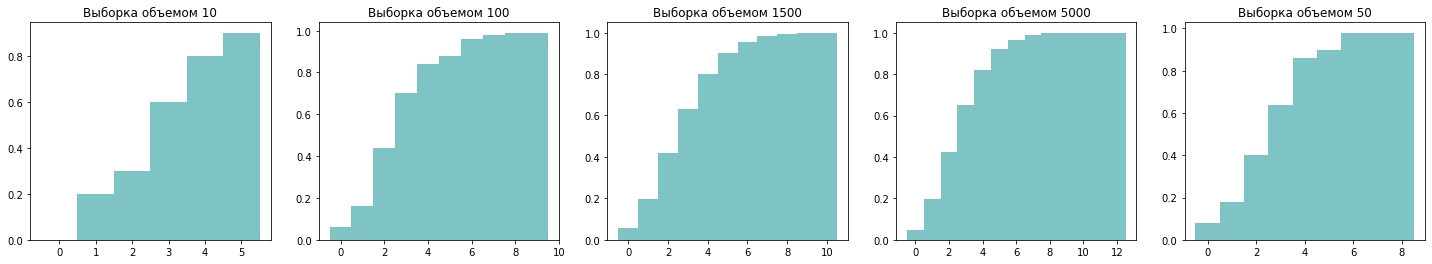

In [19]:
distrs_pois0= [pois10[0], pois100[0], pois1500[0], pois5000[0], pois105[0]]
show_emp(distrs, True)

По виду графиков можно предположить, что данные распределены по закону Пуассона с параметром $\lambda=3$.

Таким образом, гипотеза $H_0$: случайная величина Х распределена по закону Пуассона.

Применим критерий хи-квадрат для уровней значимости $\alpha=0.100$, $\alpha=0.050$

In [181]:
alphas = [0.1, 0.05]
distrs_pois = [pois10, pois100, pois1500, pois5000, pois105]
            
for distrs in distrs_pois:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} =========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} ------------------------------')
        for distr in distrs:
            print_chi2(distr, True, 3, alpha)


========================== Для выборок объемом     10 =========================
------------------------------- Для alpha =  0.1 ------------------------------
hi^2 =   2.51, hi^2_k =  9.236 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  6.626, hi^2_k =  9.236 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 = 17.454, hi^2_k =  7.779 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 = 41.691, hi^2_k = 13.362 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 =  5.601, hi^2_k =  7.779 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 ------------------------------
hi^2 =   2.51, hi^2_k =  11.07 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  6.626, hi^2_k =  11.07 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 = 17.454, hi^2_k =  9.488 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 = 41.691, hi^2_k = 15.507 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 =  5.601, hi^2_k =  9.488 => Т.к. 

#### Изменив проверяемый параметр на заведомо неверный (например, 3.5), можно заметить, что на выборках малых объемов критерий дает противоречивые результаты, однако на больших выборках гипотеза однозначно отвергается.

**Сложная гипотеза**

Гипотеза $H_0$ выглядит так:

- Данные распределены по закону Пуассона с параметром, равным оценке максимального правдоподобия для этой выборки.

В предыдущей домашней работе мы получили оценку методом максимального правдоподобия для параметра $\widehat{\lambda} = \overline{X}$. Вычислим его для всех выборок и применим критерий хи-квадрат для получившихся оценок параметров:

In [182]:
import numpy as np

for distrs in distrs_pois:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} =========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} ------------------------------')
        for distr in distrs:
            print_chi2(distr, True, np.mean(distr), alpha)


========================== Для выборок объемом     10 =========================
------------------------------- Для alpha =  0.1 ------------------------------
hi^2 =  2.704, hi^2_k =  9.236 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =   5.89, hi^2_k =  9.236 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  9.345, hi^2_k =  7.779 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 = 13.381, hi^2_k = 13.362 => Т.к. hi^2 > hi^2k, гипотеза H0 не принимается
hi^2 =  3.162, hi^2_k =  7.779 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 ------------------------------
hi^2 =  2.704, hi^2_k =  11.07 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =   5.89, hi^2_k =  11.07 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  9.345, hi^2_k =  9.488 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 = 13.381, hi^2_k = 15.507 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.162, hi^2_k =  9.488 => Т.к. 

---
#### 1.1.2 Распределение Рэлея

Возьмем выборки объемами 10, 100, 1500, 5000, 10^5 и построим графики Э.Ф.Р. для одной выборки каждого размера:

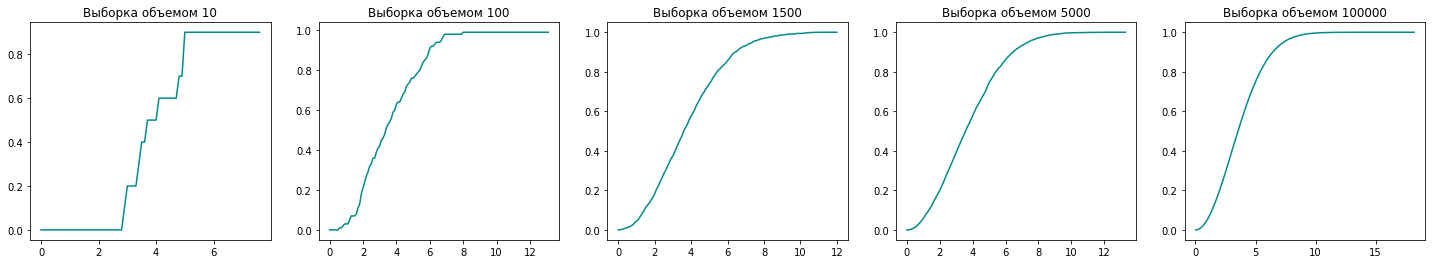

In [44]:
distrs_rayl0 = [rayl10[0], rayl100[0], rayl1500[0], rayl5000[0], rayl105[0]]

show_emp(distrs_rayl0, False)

По виду графиков можно предположить, что данные распределены по закону Рэлея с параметром $\lambda\approx3$.

Таким образом, гипотеза $H_0$: случайная величина Х распределена по закону Рэлея.

Применим критерий хи-квадрат для уровней значимости $\alpha=0.100$, $\alpha=0.050$

In [183]:
alphas = [0.100, 0.050]
distrs_rayl = [rayl10, rayl100, rayl1500, rayl5000, rayl105]

for distrs in distrs_rayl:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} =========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} ------------------------------')
        for distr in distrs:
            print_chi2(distr, False, 3, alpha)


========================== Для выборок объемом     10 =========================
------------------------------- Для alpha =  0.1 ------------------------------
hi^2 =  4.746, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.177, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  1.175, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.293, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.324, hi^2_k =  4.605 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 ------------------------------
hi^2 =  4.746, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.177, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  1.175, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.293, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.324, hi^2_k =  5.991 => Т.к. 

**Сложная гипотеза**

Гипотеза $H_0$ выглядит так:

- Данные распределены по закону Рэлея с параметром, равным оценке максимального правдоподобия для этой выборки.

В предыдущей домашней работе мы получили оценку методом максимального правдоподобия для параметра $\sigma$:

$ \widehat{\sigma} = \sqrt{\dfrac{\dfrac{1}{n}\sum\limits_{i=1}x_i^2}{2}}$

Вычислим ее для каждой выборки и применим критерий хи-квадрат для оценок параметра:

In [184]:
def estim_s(distr):
    s2 = sum(map(lambda x: x ** 2, distr))
    return math.sqrt(s2  / (2 * len(distr)))

for distrs in distrs_rayl:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} =========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} ------------------------------')
        for distr in distrs:
            print_chi2(distr, False, estim_s(distr), alpha)


========================== Для выборок объемом     10 =========================
------------------------------- Для alpha =  0.1 ------------------------------
hi^2 =  4.707, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.146, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  2.598, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  1.695, hi^2_k =  6.251 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =    3.0, hi^2_k =  4.605 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 ------------------------------
hi^2 =  4.707, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  3.146, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  2.598, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =  1.695, hi^2_k =  7.815 => Т.к. hi^2 ≤ hi^2k, гипотеза H0    принимается
hi^2 =    3.0, hi^2_k =  5.991 => Т.к. 

Итак, построим гипотезы $H_0$. Они будут одинаковы для всех трех выборок:

- Данные распределены по закону Рэлея с параметром 3.

Вычисления будут аналогичны проверкам простых гипотез.

---
### 1.2 Критерий согласия Колмогорова-Смирнова (для непрерывного распределения)

Данный критерий основан на сравнении Э.Ф.Р. с предполагаемой функцией распределения, а именно: в качестве __меры расхождения__ используется максимум абсолютного значения разности Э.Ф.Р. и Т.Ф.Р.

Таким образом, $D_n=max\left|F_n(x)-F(x)\right|$ -- статистика критерия Колмогорова.

При $n\rightarrow\infty$ $P(D_n\sqrt{n} \geqslant \lambda)$ стремится к распределению Колмогорова $ P(\lambda)=1 - \sum\limits_{k=-\infty}^{+\infty}(-1)^ke^{-2k^2\lambda^2}$.

Если $H_0$ -- гипотеза о виде распределения, то, чтобы определиться, принимать ее или нет, необходимо вычислить $\lambda=D_n\sqrt{n}$ и сравнить с $\lambda_\alpha$ (находится по таблице), где $\alpha$ -- уровень значимости. Если $D_n\sqrt{n} \leq \lambda$, то гипотеза принимается.

Вместо $\lambda=D_n \sqrt{n}$ лучше использовать вид статистики с поправкой Большева: $\lambda=S=\dfrac{6nD_n+1}{6\sqrt{n}}$, т.к. к распределению Колмогорова он сходится быстрее.

**Достоинство** данного критерия в том, что он может применяться на выборках в том числе малых объемом. __Недостаток__ же -- возможность использования только для непрерывных распределений.

In [190]:
def n_dn (distr, par):
    xx = np.arange(0, max(distr), 0.1)
    empf = emp(distr)
    fn = np.array([empf(x) for x in xx])
    f = np.array([F_Rayl(x, par) for x in xx])
    dn = max(abs(fn-f))
    return dn

l_set = {'0.1': 1.22, '0.05': 1.36}

def print_kstest(distr, par, alpha):
    n = len(distr)
    dn = n_dn(distr, par)
    s = (6 * n * dn + 1) / (6 * math.sqrt(n))
    la = l_set[str(alpha)]
    print(f'Dn = {dn:.3f}, l = S = {s:.3f}, la = {la:.3f}', end=' ')
    print(f'=> Т.к. l {"≤" if s <= la else ">"} la, гипотеза H0 {"не" if s > la else "  "} принимается')

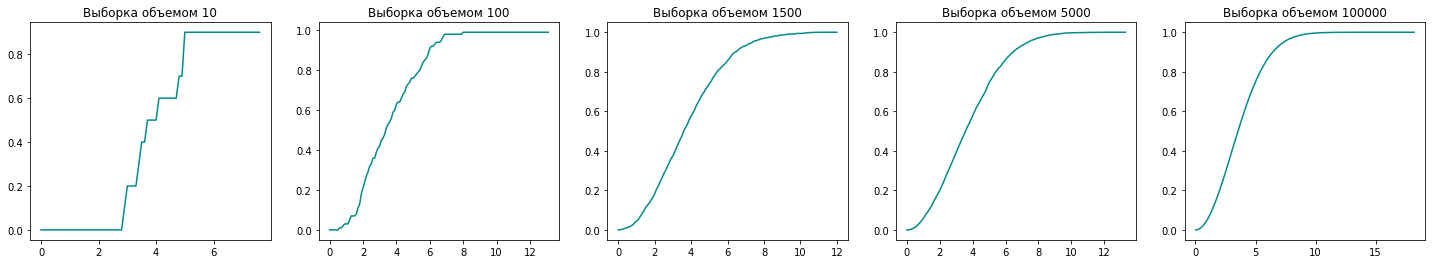

In [60]:
distrs_rayl0 = [rayl10[0], rayl100[0], rayl1500[0], rayl5000[0], rayl105[0]]

show_emp(distrs_rayl0, False)

По виду графиков можно предположить, что данные распределены по закону Рэлея с параметром $\lambda\approx3$.

Таким образом, гипотеза $H_0$: случайная величина Х распределена по закону Рэлея с параметром 3.

Применим критерий Колмогорова-Смирнова для уровней значимости $\alpha=0.1$, $\alpha=0.05$:

In [191]:
alphas = ['0.1', '0.05']
            
for distrs in distrs_rayl:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} ==========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} -------------------------------')
        for distr in distrs:
            print_kstest(distr, 3, alpha)


========================== Для выборок объемом     10 ==========================
------------------------------- Для alpha = 0.1  -------------------------------
Dn = 0.217, l = S = 0.740, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.270, l = S = 0.908, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.160, l = S = 0.557, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.267, l = S = 0.898, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.211, l = S = 0.720, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 -------------------------------
Dn = 0.217, l = S = 0.740, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.270, l = S = 0.908, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.160, l = S = 0.557, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.267, l = S = 0.898, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.211, l = S = 0.720, 

**Сложная гипотеза**

Гипотеза $H_0$ выглядит так:

- Данные распределены по закону Рэлея с параметром, равным оценке максимального правдоподобия для этой выборки.

В предыдущей домашней работе мы получили оценку методом максимального правдоподобия для параметра $\sigma$:

$ \widehat{\sigma} = \sqrt{\dfrac{\dfrac{1}{n}\sum\limits_{i=1}x_i^2}{2}}$

Вычислим ее для каждой выборки и применим критерий Колмогорова-Смирнова для оценок параметра:

In [192]:
for distrs in distrs_rayl:
    print(f'\n========================== Для выборок объемом {len(distrs[0]):6} ==========================')
    for alpha in alphas:
        print(f'------------------------------- Для alpha = {alpha:4} -------------------------------')
        for distr in distrs:
            print_kstest(distr, estim_s(distr), alpha)


========================== Для выборок объемом     10 ==========================
------------------------------- Для alpha = 0.1  -------------------------------
Dn = 0.226, l = S = 0.768, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.265, l = S = 0.891, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.207, l = S = 0.707, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.096, l = S = 0.357, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.187, l = S = 0.643, la = 1.220 => Т.к. l ≤ la, гипотеза H0    принимается
------------------------------- Для alpha = 0.05 -------------------------------
Dn = 0.226, l = S = 0.768, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.265, l = S = 0.891, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.207, l = S = 0.707, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.096, l = S = 0.357, la = 1.360 => Т.к. l ≤ la, гипотеза H0    принимается
Dn = 0.187, l = S = 0.643, 

---
### 1.3 Критерий однородности Колмогорова-Смирнова

Критерий однородности Колмогорова-Смирнова применяется, когда нужно узнать, принадлежат ли две выборки одному и тому же распределению. Т.е. гипотеза $H_0$ выглядит так:
- Функции распределения двух выборок одинаковы

Если $n_1$, $n_2$ -- объемы двух сравниваемых выборок, $F_{n_1},\; F_{n_2}$ -- эмпирические функции распределения этих выборок, то статистика критерия имеет вид:
$\lambda=\sqrt{\dfrac{n_1n_2}{n_1+n_2}} \cdot max \left| F_{n_1} - F_{n_2}\right|$

Если $\lambda_\alpha$ -- табличное критическое значение статистики, то гипотеза $H_0$ принимается, когда $\lambda ≤ \lambda_\alpha$.

Проведем сравнение наших сгенерированных выборок с помощью критерия Колмогорова-Смирнова. Для выборок одинакового объема возьмем по три выборки (три комбинации по 2), для разного объема -- по две выборки каждого объема (4 комбинации по 2).

In [310]:
from itertools import combinations, product

# Функция работает только для сравнения распр. одного типа (дискретных/непрерывных)
def s_test(comb):
    n1 = len(comb[0])
    n2 = len(comb[1])
    k = math.sqrt(n1 * n2 / (n1 + n2))
    emp1 = emp(comb[0])
    emp2 = emp(comb[1])
    # Берем самый макс.знач., чтобы определиться, для каких x будем считать эмпирические
    max12 = max(max(comb[0]), max(comb[1]))
    # Проверка на дискретность распределений
    my_range = range(max12) if isinstance(max12, int) else np.arange(0, max12, 0.1)
    m_dif = max(list(map(lambda x: abs(emp1(x) - emp2(x)), my_range)))
    return k * m_dif

def print_s_test(distrs, alpha, is_eq_n):
    '''
    Для выборок разного объема необх. задавать в distrs сначала две одного объема, потом две другого
    '''
    if is_eq_n:
        combs = list(combinations(distrs, 2))
        print(f'--------------- Для выборок объемом {len(distrs[0]):6} ---------------')
    else:
        combs = list(product(distrs[0], distrs[1]))
        print(f'----------- Для выборок объемов {len(distrs[0][0]):4} и {len(distrs[1][0]):6} ------------')
    for comb in combs:
        l = np.round(s_test(comb), 3)
        la = l_set[str(alpha)]
        print(f'l = {l:5}, la = {la}'\
        f', l {"⩽" if l <= la else ">"} la => гипотеза H0 {"не" if l > la else "  "} принимается')

In [300]:
poiss10 = [pois10[0], pois10[1], pois10[2]]
poiss100 = [pois100[0], pois100[1], pois100[2]]
poiss1500 = [pois1500[0], pois1500[1], pois1500[2]]
poiss105 = [pois105[0], pois105[1], pois105[2]]

poiss10_100 = [[pois10[0], pois10[1]], [pois100[0], pois100[1]]]
poiss10_1500 = [[pois10[0], pois10[1]], [pois1500[0], pois1500[1]]]
poiss1500_105 = [[pois1500[0], pois1500[1]], [pois105[0], pois105[1]]]

In [311]:
print('================= РАСПРЕДЕЛЕНИЕ ПУАССОНА =================')
for alpha in alphas:
    print(f'\n=============== Для уровня значимости {alpha:4} ===============')
    for comb in [poiss10, poiss100, poiss1500, poiss105]:
        print_s_test(comb, alpha, True)
    for comb in [poiss10_100, poiss10_1500, poiss1500_105]:
        print_s_test(comb, alpha, False)

================= РАСПРЕДЕЛЕНИЕ ПУАССОНА =================

=============== Для уровня значимости 0.1  ===============
--------------- Для выборок объемом     10 ---------------
l = 0.671, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.894, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.671, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом    100 ---------------
l = 0.354, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.566, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.354, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом   1500 ---------------
l = 0.456, la = 1.22, l ⩽ la => гипотеза H0    принимается
l =  0.42, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.219, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом 100000 ---------------
l = 0.702, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.664, la = 1.22, l ⩽ la => гипотеза H0    принимае

In [250]:
rayll10 = [rayl10[0], rayl10[1], rayl10[2]]
rayll100 = [rayl100[0], rayl100[1], rayl100[2]]
rayll1500 = [rayl1500[0], rayl1500[1], rayl1500[2]]
rayll105 = [rayl105[0], rayl105[1], rayl105[2]]

rayll10_100 = [[rayl10[0], rayl10[1]], [rayl100[0], rayl100[1]]]
rayll10_1500 = [[rayl10[0], rayl10[1]], [rayl1500[0], rayl1500[1]]]
rayll1500_105 = [[rayl1500[0], rayl1500[1]], [rayl105[0], rayl105[1]]]

In [312]:
print('================== РАСПРЕДЕЛЕНИЕ РЭЛЕЯ ===================')
for alpha in alphas:
    print(f'\n=============== Для уровня значимости {alpha:4} ===============')
    for comb in [poiss10, poiss100, poiss1500, poiss105]:
        print_s_test(comb, alpha, True)
    for comb in [poiss10_100, poiss10_1500, poiss1500_105]:
        print_s_test(comb, alpha, False)

================== РАСПРЕДЕЛЕНИЕ РЭЛЕЯ ===================

=============== Для уровня значимости 0.1  ===============
--------------- Для выборок объемом     10 ---------------
l = 0.671, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.894, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.671, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом    100 ---------------
l = 0.354, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.566, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.354, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом   1500 ---------------
l = 0.456, la = 1.22, l ⩽ la => гипотеза H0    принимается
l =  0.42, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.219, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом 100000 ---------------
l = 0.702, la = 1.22, l ⩽ la => гипотеза H0    принимается
l = 0.664, la = 1.22, l ⩽ la => гипотеза H0    принимае

Можно попробовать сравнить выборки разных распределений. На маленьких выборках критерий может ошибаться, но на средних больших выдает верный результат:

In [315]:
print_s_test([pois10[0], rayl10[0]], 0.1, True)
print_s_test([pois100[0], rayl100[0]], 0.1, True)
print_s_test([pois1500[0], rayl1500[0]], 0.1, True)
print_s_test([pois105[0], rayl105[0]], 0.1, True)

--------------- Для выборок объемом     10 ---------------
l = 1.118, la = 1.22, l ⩽ la => гипотеза H0    принимается
--------------- Для выборок объемом    100 ---------------
l = 2.121, la = 1.22, l > la => гипотеза H0 не принимается
--------------- Для выборок объемом   1500 ---------------
l = 6.646, la = 1.22, l > la => гипотеза H0 не принимается
--------------- Для выборок объемом 100000 ---------------
l = 57.72, la = 1.22, l > la => гипотеза H0 не принимается


---
## 2. Проверка параметрических гипотез
---

### 1. Данные

Будем работать с распределением Пуассона. Возьмем выборку объемом 5000: с параметром $\lambda=5$.

In [295]:
v = rand_Pois(5, 5000)

### 2. Постановка задачи 

Пусть известно, что данные распределены по закону Пуассона, но не известен параметр $\lambda$ распределения.
Сформулируем гипотезы.

- $H_0$: $\lambda$ = 5

- $H_1$: $\lambda$ = 7

Ошибкой 1-го рода $\alpha$ называют отвержение $H_0$, когда она истинна. Ошибкой 2-го рода $\beta$ -- принятие $H_0$ за истинную, когда она ложна.

В случае, когда $H_0,\;H_1$ -- простые, $\alpha = P(x \in X_{1\alpha} | H_0)$, $\beta = P(x \in X_{0\alpha}|H_1) = 1 - P(x \in X_{1\alpha}|H_1)$.

Функция мощности определяется как функционал на множестве допустимых распределений $\mathcal{F}$ и выборке $X$: $w(F)=P(X \in X_{1\alpha} | F)$. Для критериев, основанных на выборке фиксированного объема, $w(F)=1-\beta$. 

### 3. Вычисление функции отношения правдоподобия

Вычисление функция отношения правдоподобия происходит по формуле $l(x)=\dfrac{L(X, \theta_1)}{L(X, \theta_2)}$, где $L(X, \theta)$ -- функция правдоподобия.

Для распределения Пуассона $L(\vec{x}, \lambda)=\prod\limits_{i=1}^n f(x_i,\lambda)=\prod_{i=1}^n\dfrac{\lambda^{x_i}}{x_i!}\cdot e^{-\lambda}=e^{-n\lambda}\prod_{i=1}^n\dfrac{\lambda^{x_i}}{x_i!}$

Данная функция используется в критерии выбора из простых $H_0, \; H_1$: $H_0$ принимается, если $l(x) \leq c$.

### 4. Вычисление критической области

Чтобы выбрать c, найдем распределение $l(x)$.

$lnL=-n\lambda+ln\lambda\sum\limits_{i=1}^n(x_i)-\sum\limits_{i=1}^n ln(x_i)!$

$ln(l(x))=ln(L(X, \lambda_1)) - ln(L(X, \lambda_2)) = -n(\lambda_1 - \lambda_2) + \sum\limits_{i=1}^n(x_i)\cdot(ln\lambda_1 - ln\lambda_2) = n(\lambda_2 - \lambda_1) + ln\dfrac{\lambda_1}{\lambda_2}\sum\limits_{i=1}^n x_i \geq c' = ln\; c$

$\sum\limits_{i=1}^n x_i \geq $

